In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from package.RankAMIP.logistic import run_logistic_regression
from package.RankAMIP.data_script import make_BT_design_matrix
from package.RankAMIP.logistic import LogisticAMIP
from package.RankAMIP.logistic import find_closest_matchups
from package.RankAMIP.logistic import isRankingRobust

### Is Chatbot Arena (LLM Judge version) Data-Dropping Robust?

### Data Pre-processing

In [3]:
# Import datasets from https://huggingface.co/datasets/potsawee/chatbot-arena-llm-judges
from datasets import load_dataset
ds = load_dataset("potsawee/chatbot-arena-llm-judges")

README.md:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.single-turn.json:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49938 [00:00<?, ? examples/s]

In [4]:
# inspect the available splits
print(ds)  
# grab the ‘train’ split (or whatever splits ds has)
train = ds["train"]
# look at the first example
print(train[0])

DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'winner_model_a', 'winner_model_b', 'winner_tie', 'question', 'answer_a', 'answer_b'],
        num_rows: 49938
    })
})
{'id': 65089, 'model_a': 'gpt-3.5-turbo-0613', 'model_b': 'mistral-medium', 'winner_model_a': 0, 'winner_model_b': 0, 'winner_tie': 1, 'question': 'explain function calling. how would you call a function?', 'answer_a': 'Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function\'s name followed by parentheses "()". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a function in Python:\n\n```python\n# Define a function\ndef greet(name):\n    print("Hello, " + name + "!")\n\n# Call the function\ngreet("John")\n```\n\nIn this example, the function "greet" is defined with a single parameter "name" which is used to print a greeting message. To 

In [5]:
df = train.to_pandas()
df.head()

,id,model_a,model_b,winner_model_a,winner_model_b,winner_tie,question,answer_a,answer_b
0,65089,gpt-3.5-turbo-0613,mistral-medium,0,0,1,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...
1,96401,llama-2-13b-chat,mistral-7b-instruct,1,0,0,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...
2,198779,koala-13b,gpt-3.5-turbo-0314,0,1,0,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...
3,292873,vicuna-13b,gpt-4-0314,0,1,0,"Construct a rap battle, in the style of Epic R...","[Zeus]\nYo, it's the king of the gods on the m...","(Verse 1 - Zeus)\n\nI'm the king of the gods, ..."
4,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,1,0,0,Why water is not used in bath tub?,Water is actually used in a bath tub. A bath t...,Water is not used in a bath tub because it is ...


In [6]:
# how to get the unique names in both columns
model_a_names = df['model_a'].unique()
model_b_names = df['model_b'].unique()
# combine the two arrays and get the unique names
model_names = np.unique(np.concatenate((model_a_names, model_b_names)))
# print the number of unique model names
print(f"Number of unique model names: {len(model_names)}")

Number of unique model names: 64


In [15]:
ties = df[df['winner_tie'] == 1]
print(f"Number of ties: {len(ties)}")
# proportion of ties.
print(f"Proportion of ties: {len(ties) / len(df):.2%}")

Number of ties: 15641
Proportion of ties: 31.32%


There are 15641 ties in the data set.

In [29]:
def break_ties_randomly(df, seed):
    np.random.seed(seed)
    tie_indices = df[df['winner_tie'] == 1].index
    # Random choices: 1 means assign to model_a, 0 to model_b
    assign_to_a = np.random.choice([0, 1], size=len(tie_indices))
    
    for idx, assign in zip(tie_indices, assign_to_a):
        if assign == 1:
            df.at[idx, 'winner_model_a'] = 1
            df.at[idx, 'winner_model_b'] = 0
        else:
            df.at[idx, 'winner_model_a'] = 0
            df.at[idx, 'winner_model_b'] = 1
    
    return df

In [ ]:
df_no_ties = break_ties_randomly(df,seed=0)
# df_no_ties.head(20)
df_no_ties.shape
# select the model_a, model_b, and winner columns
rawBT = df_no_ties[['model_a', 'model_b', 'winner_model_a']]
rawBT.head()
# make a design matrix.
# X, y, player_to_id = make_BT_design_matrix(rawBT)
###

In [78]:
### Move 'gpt-4-1106-preview' to index 0.
# Find all rows where gpt-4-1106-preview appears in model_a or model_b
mask = (df['model_a'] == 'gpt-4-1106-preview') | (df['model_b'] == 'gpt-4-1106-preview')
# Reorder the DataFrame: put matching rows first, then the rest
df = pd.concat([df[mask], df[~mask]]).reset_index(drop=True)
df

,id,model_a,model_b,winner_model_a,winner_model_b,winner_tie,question,answer_a,answer_b
0,887722,gpt-4-1106-preview,wizardlm-70b,1,0,0,Write a grammatically correct sentence without...,A lynx jumps quick.,The quick onyx goblin jumps over a lazy dwarf.
1,2298796,gpt-4-1106-preview,claude-2.1,1,0,0,make a haiku on bacon the food,"Crisp strips of delight,\nSizzling dance, morn...",Here is a haiku about bacon:\n\nSizzling in pa...
2,2912862,gpt-4-1106-preview,gpt-4-0613,0,1,0,"texts = [text.split() for text in df[""text_pro...",The code snippet you provided is used to creat...,The code you've provided is writing a vocab fi...
3,4970917,gpt-4-1106-preview,yi-34b-chat,1,0,0,Why does tpm 2.0 provide the concept of multip...,TPM (Trusted Platform Module) 2.0 provides the...,TPM 2.0 (Trusted Platform Module) provides the...
4,6817408,gpt-4-1106-preview,gpt-3.5-turbo-0125,1,0,0,"There is a rainstorm, there is thunder and lig...","As an artificial intelligence, I don't have ph...","I'm sorry, but I am unable to observe the rain..."
...,...,...,...,...,...,...,...,...,...
49933,4294349169,palm-2,guanaco-33b,0,1,0,Schreibe ein Bewerbungsanschreiben in deutsch ...,I am trained to understand and respond only to...,Here is a possible Bewerbungsanschreiben in de...
49934,4294633312,pplx-7b-online,gpt-4-0613,1,0,0,abc,It seems like you're referring to the Californ...,"Hello! It seems like you've typed ""abc."" How m..."
49935,4294656694,gpt-4-0613,claude-1,1,0,0,"A simple mnemonic for π:\n""How I wish I could ...","Sure, let's break it down:\n\n1. ""How"" has 3 l...",Here is how that mnemonic represents the digit...
49936,4294692063,claude-2.0,llama-2-13b-chat,1,0,0,"In python, implement a naive Bayes with gaussi...",Here is an implementation of a naive Bayes cla...,Sure! Here's an implementation of a naive Baye...


In [79]:
new_rawBT = df[['model_a', 'model_b', 'winner_model_a']]

In [80]:
all_players = pd.concat([new_rawBT.iloc[:, 0], new_rawBT.iloc[:, 1]])
unique_players = all_players.unique()
player_to_id = {player: idx for idx, player in enumerate(unique_players)}
player_to_id

{'gpt-4-1106-preview': 0,
 'claude-1': 1,
 'deepseek-llm-67b-chat': 2,
 'gpt-4-0613': 3,
 'gpt-3.5-turbo-0613': 4,
 'palm-2': 5,
 'gemini-pro': 6,
 'claude-instant-1': 7,
 'claude-2.1': 8,
 'gpt-3.5-turbo-1106': 9,
 'mistral-medium': 10,
 'mixtral-8x7b-instruct-v0.1': 11,
 'llama2-70b-steerlm-chat': 12,
 'claude-2.0': 13,
 'solar-10.7b-instruct-v1.0': 14,
 'llama-2-7b-chat': 15,
 'openchat-3.5': 16,
 'gemini-pro-dev-api': 17,
 'gpt-4-0125-preview': 18,
 'stripedhyena-nous-7b': 19,
 'mistral-7b-instruct': 20,
 'tulu-2-dpo-70b': 21,
 'qwen-14b-chat': 22,
 'nous-hermes-2-mixtral-8x7b-dpo': 23,
 'codellama-34b-instruct': 24,
 'chatglm3-6b': 25,
 'llama-2-70b-chat': 26,
 'gpt-4-0314': 27,
 'llama-2-13b-chat': 28,
 'wizardlm-70b': 29,
 'vicuna-33b': 30,
 'pplx-70b-online': 31,
 'zephyr-7b-beta': 32,
 'openhermes-2.5-mistral-7b': 33,
 'pplx-7b-online': 34,
 'qwen1.5-4b-chat': 35,
 'starling-lm-7b-alpha': 36,
 'vicuna-13b': 37,
 'dolphin-2.2.1-mistral-7b': 38,
 'yi-34b-chat': 39,
 'gpt-3.5-tur

In [81]:
# make a design matrix.
X, y, player_to_id = make_BT_design_matrix(new_rawBT)
X.shape, y.shape

((49938, 63), (49938,))

#### Robustness results are dependent on how ties are broken 
changing the random seed changes robustness results.

In [ ]:
rs_results = []
for rand_seed in range(10):
    df_no_ties = break_ties_randomly(df,seed=rand_seed)
    # df_no_ties.head(20)
    df_no_ties.shape
    # select the model_a, model_b, and winner columns
    rawBT = df_no_ties[['model_a', 'model_b', 'winner_model_a']]
    rawBT.head()
    # make a design matrix.
    X, y, player_to_id = make_BT_design_matrix(rawBT)
    ###
    myAMIP = LogisticAMIP(X, y, fit_intercept=False, penalty=None)
    results = myAMIP.AMIP_sign_change(10, 8, 54)
    rs_results.append(results)

In [26]:
# fraction of times the tie-broken arena is non-robust to dropping 10 points
sum([rs_results[i][0] for i in range(len(rs_results))]) / len(rs_results)

0.28

In [82]:
ks = [1]
alphaNs = [10]

results = {}
for k in ks:
    for alphaN in alphaNs:
        chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices = isRankingRobust(k, alphaN, X, y)
        results[(k, alphaN)] = (chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices)

testing new matchup:  17 None


In [83]:
results

{(1, 10): (17,
  None,
  0.0026024924730338717,
  -0.02396859349223792,
  array([3576, 4732, 3474, 3467, 4078, 3878, 3594, 3333, 5321, 3452]))}

In [84]:
import importlib
import package.RankAMIP.plot_util
from package.RankAMIP.plot_util import *
# Make changes to your_local_module.py file
# Then reload it
importlib.reload(package.RankAMIP.plot_util)

<module 'package.RankAMIP.plot_util' from '/Users/JennyH/Desktop/IsRankingRobust/package/RankAMIP/plot_util.py'>

In [85]:
from package.RankAMIP.plot_util import *
rankings = return_rankings_list(X, y, results, 1, 10, player_to_id)

In [86]:
rankings

[['gpt-4-0125-preview', 18, 0.0026024924730338717, -0.02396859349223943],
 ['gpt-4-1106-preview', 0, 0.0, 0.0],
 ['gpt-4-0314', 27, -0.4466479751970804, -0.4497380659693182],
 ['gpt-4-0613', 3, -0.5161884248635411, -0.5196444422371422],
 ['qwen1.5-72b-chat', 46, -0.5218350419727554, -0.5258672359642155],
 ['mistral-medium', 10, -0.6171203954360842, -0.6209980561245062],
 ['claude-1', 1, -0.7077837419976254, -0.7109940319686314],
 ['claude-2.0', 13, -0.7658476724968981, -0.7689856198288681],
 ['mixtral-8x7b-instruct-v0.1', 11, -0.7732079432537013, -0.7764696103440254],
 ['pplx-70b-online', 31, -0.808559912704744, -0.8119145372406439],
 ['gemini-pro-dev-api', 17, -0.8102657362736995, -0.8135107100566333],
 ['gemini-pro', 6, -0.8104545330582861, -0.8132077889560468],
 ['starling-lm-7b-alpha', 36, -0.815190471882832, -0.8186996566623715],
 ['gpt-3.5-turbo-0613', 4, -0.8651733305638907, -0.8686675671609939],
 ['claude-2.1', 8, -0.8715399571415877, -0.8748098207765792],
 ['wizardlm-70b', 29,

In [87]:
filename_to_save = 'fig/llm_judge.png'
plot_bt_scores(X, y, rankings, alphaN, 20, filename_to_save)

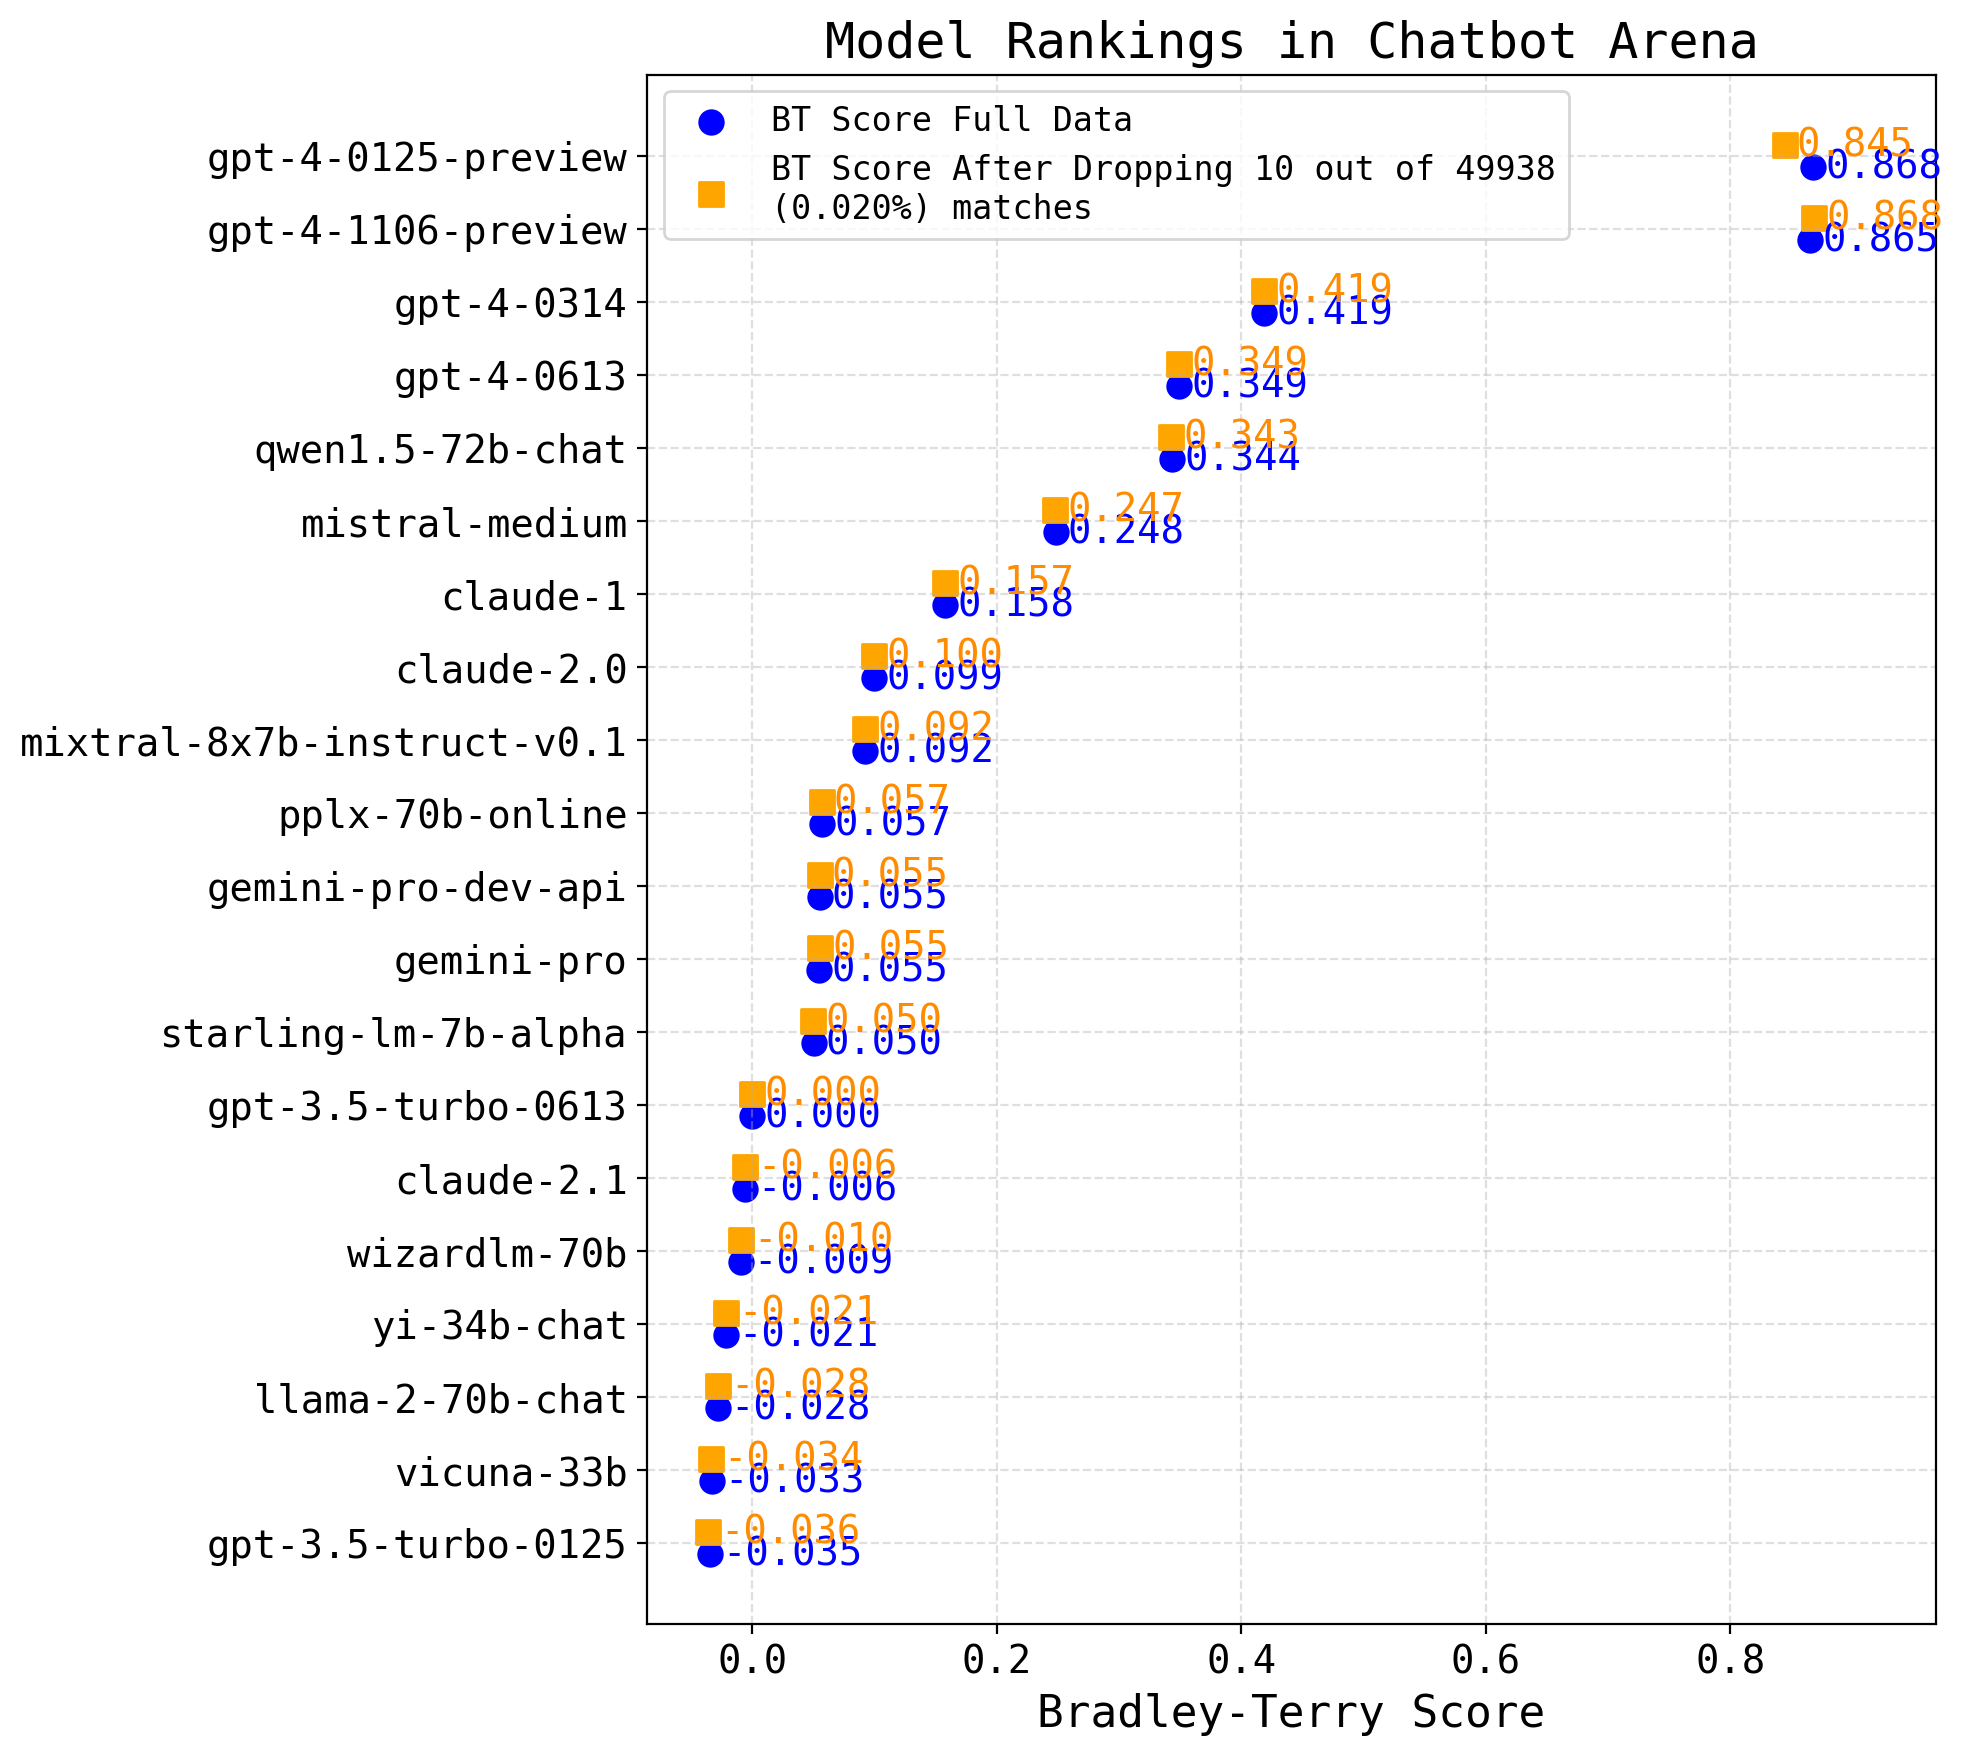

In [50]:
topk = 20
# Extract top-k entries
# Sorted by old_scores (index 2) in descending.
rankings_topk = sorted(rankings[:topk], key=lambda x: x[2], reverse=False)
model_names = [x[0] for x in rankings_topk[:topk]]
old_scores = [x[2] for x in rankings_topk[:topk]]
new_scores = [x[3] for x in rankings_topk[:topk]]
num_matches_total = len(y)
y_plot = np.arange(len(rankings_topk[:topk]))
offset = 0.15

# Plot
import matplotlib.pyplot as plt

# Set global font to monospace and increase default font size
plt.rcParams.update({
    'font.family': 'monospace',
    'font.size': 14
})

# Plot
plt.figure(figsize=(10, 9), dpi=200)

# Scatter points
plt.scatter(old_scores, y_plot - offset, label='BT Score Full Data', marker='o', color='blue', s=72)
plt.scatter(new_scores, y_plot + offset, 
            label=f'BT Score After Dropping {alphaN} out of {num_matches_total}\n'
                  f'({(alphaN/num_matches_total * 100):.3f}%) matches',
            marker='s', color='orange', s=72)

# Extend x-axis limits slightly to the left and right
min_score = min(min(old_scores), min(new_scores))
max_score = max(max(old_scores), max(new_scores))
plt.xlim(min_score - 0.05, max_score + 0.1)

# Annotate scores next to points
for i in range(len(y_plot)):
    plt.text(old_scores[i] + 0.01, y_plot[i] - offset, f'{old_scores[i]:.3f}', 
             va='center', ha='left', fontsize=14, fontfamily='monospace', color='blue')
    plt.text(new_scores[i] + 0.01, y_plot[i] + offset, f'{new_scores[i]:.3f}', 
             va='center', ha='left', fontsize=14, fontfamily='monospace', color='darkorange')

# Axis formatting
plt.xlabel('Bradley-Terry Score', fontsize=16, fontfamily='monospace')
plt.yticks(y_plot, model_names, fontsize=14, fontfamily='monospace')
plt.xticks(fontsize=14, fontfamily='monospace')
plt.title('Model Rankings in Chatbot Arena', fontsize=18, fontfamily='monospace')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


We find that the score for gpt-4-0125-preview flips with that of gpt-4-1106-preview with only 10 out of 50k matches dropped. These were the original first and second-ranking models, by quite a landslide.

### Inspect the dropped human evals.

In [ ]:
# check the human evals that were dropped to change the top model.
# dropped comparisons: 
# get the rows in df that have these indices.
mis_df = df.iloc[indices][['model_a', 'model_b', 'winner_model_a', 'winner_tie']]
mis_df
# save the df to a csv file.
# mistral_df.to_csv('fig/mistral_df.csv', index=False)


,model_a,model_b,winner_model_a,winner_tie
45535,gpt-4-0125-preview,gpt-4-1106-preview,1,0
13696,gpt-4-0125-preview,gpt-4-1106-preview,1,0
4566,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12544,gpt-4-0125-preview,gpt-4-1106-preview,1,0
35786,gpt-4-0125-preview,gpt-4-1106-preview,1,1
7657,gpt-4-0125-preview,gpt-4-1106-preview,1,0
44022,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12586,gpt-4-0125-preview,gpt-4-1106-preview,1,1
57338,gpt-4-0125-preview,gpt-4-1106-preview,1,0
7386,gpt-4-0125-preview,gpt-4-1106-preview,1,1


In [238]:
# MIS: prompts.
for prompt in df.iloc[indices[:5]]['prompt'].tolist():
    print(prompt)


["Why am I so happy after drinking alcohol? It's like I have forgotten all my problems, and I don't feel anything but happy and calm."]
["what is 1 plus 1"]
["how many lights do I have in my home"]
["Continue this list with plausible social groups, ideology and accusation:\n\nSocial group\tTheory\/ideology\tAccusation\nJews\tZionism\tAntisemitism\nWomen\tFeminism\tSexism\/misogyny\nTrans\tGender identity ideology\tTransphobia\nBlack\tCritical race theory\tRacism\nChinese\tChinese Communist Party\tAnti-Chinese\nVeterans\tJustice of war\tDisrespect of veterans\nSports fans\tValue of sports\tAnti-Australians\nMen\tMale violence\tMisandry\nMuslims\tIslam\tIslamophobia\nMuslims\tHalal\tIslamophobia\nSex workers\tSex market as good\tAnti-sex worker\nAcademics\tLimit population growth\tRacist\/eugenicist\/colonial\nAmericans\tUS foreign policy\tAnti-American\nCatalans\tSeparatism\tCatalanophobia\nLesbians\tSeparatism \tMan-hating\nGay men\tMisogyny\tHomophobia\nWomen\tFemininity \tWoman-hatin

In [239]:
# MIS: response A.
for responseA in df.iloc[indices[:5]]['response_a'].tolist():
    print(responseA)

["Alcohol can make you feel happy and relaxed because it can affect the levels of certain neurotransmitters in your brain, such as dopamine and serotonin. These chemicals are naturally produced in your brain and can contribute to feelings of pleasure and well-being. When you consume alcohol, it can increase the levels of these neurotransmitters, leading to feelings of happiness and relaxation.\n\nHowever, it is important to note that alcohol can also have negative effects on your mental and physical health, and it is not a healthy or sustainable way to cope with problems or stress. If you are relying on alcohol to feel happy or calm, it may be helpful to speak with a mental health professional about healthier ways to manage your emotions and cope with stress."]
["The sum of 1 plus 1 is 2. In mathematical terms, if you have one object or value, and you add another one, the total number of objects or values you have is the sum of the two, which is 2 in this case."]
["I'm just an AI, I do

In [240]:
# MIS: response B.
for responseB in df.iloc[indices[:5]]['response_b'].tolist():
    print(responseB)

["Alcohol is a central nervous system depressant that can have various effects on mood and emotions. When you consume alcohol, it can cause the release of certain chemicals in the brain, such as endorphins and dopamine, which are associated with feelings of happiness and pleasure. Alcohol can also help to decrease anxiety and inhibitions, making you feel more relaxed and calm. However, it's important to note that these effects are temporary, and the negative consequences of alcohol consumption, such as hangovers and long-term health problems, can outweigh the initial pleasurable feelings. Additionally, relying on alcohol as a way to cope with problems or negative emotions can lead to dependence and addiction. If you are concerned about your alcohol consumption or are experiencing negative consequences, it may be helpful to speak with a healthcare professional or substance abuse counselor."]
["The answer to 1 plus 1 is 2."]
["I'm unable to provide an exact answer to that question as I d